# ***CSYE 7370 Deep Learning and Reinforcement Learning in Game Engineering*** 



# Mini Project 2: Open AI-gym MountainCarContinuous-v0 control problem sovled using Actor-Critic Algorithm

### Notice: Since I want to use gym.render but it doesn't work on google colab so I have to use Jupyter notebook to write and run all the code.

In [14]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
env = gym.make('MountainCarContinuous-v0')
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

## mountain car env.

$ state=[x,v]$ where $x \in [-1.2,0.5]$ and $v \in [-0.07,0.07]$(continuous value)

$ action \in [-1,1]$

$ reward =  -a^2 $ if $x<0.5$, $100-a^2$ if $x>=0.5$

 I have used following parameterized policies-
 -  $\pi_{\theta}(s,a)=\theta^T.z = h(z)$ where $ \theta \in R^4$ and $ z=[1,x,v,a]^T$ , $x \to position$ $v \to velocity$ and $ a \to action$,
 - $\pi_{\theta}(s,a)= sin(h(z))$ where h(z) is the above function.
 - $\pi_{\theta}(s,a)= tanh(h(z))$. and
 - $\pi_{\theta}(a/s)=N(\mu,\sigma)$ where $\mu=\theta^T.z$ and $\sigma=1$ as constant (also took other values)
 
 and tried reinforce algorithm to solve the mountain-car problem but this is not work. so I switched to parameterized policy with deep learning. and used actor-critic algorithm.

Below are the concepts I learned from Professor's class and I was inspired by the article - https://medium.com/@asteinbach/actor-critic-using-deep-rl-continuous-mountain-car-in-tensorflow-4c1fb2110f7c 

## Actor-Critic Algorithm
 
- $\textbf{Actor} $

    policy function $\pi_{\theta}(a/s)=N(\mu,\sigma)$

    loss function  $-log(N(a|\mu(s_t),\sigma(s_t)).(G_t-v(s_t,w))$
 
- $\textbf{Critic}$ 
 
    state value function $v(s,w)$

    loss function $(G_t-v(s_t,w))^2$

where $\theta$ and w are Deep-Neural-Network parameter

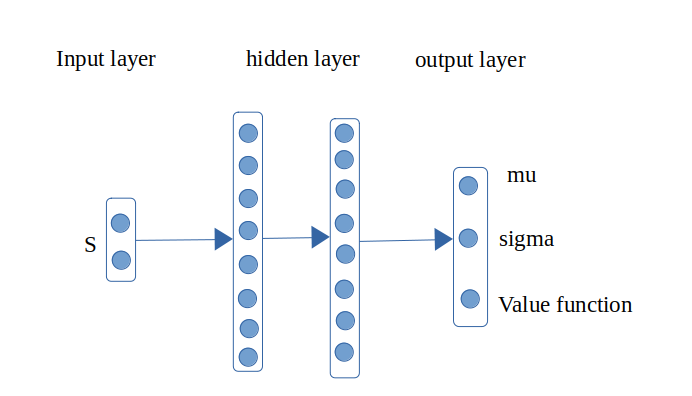
<caption><center> <u> <font color='purple'> Figure 1 </u><font color='purple'>  : Model-Architecture  </center></caption>


ActorCriticModel(

  (fc1): Linear(in_features=2, out_features=200, bias=True)
  
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  
  (mu): Linear(in_features=200, out_features=1, bias=True)
  
  (sigma): Linear(in_features=200, out_features=1, bias=True)
  
  (value): Linear(in_features=200, out_features=1, bias=True)
)

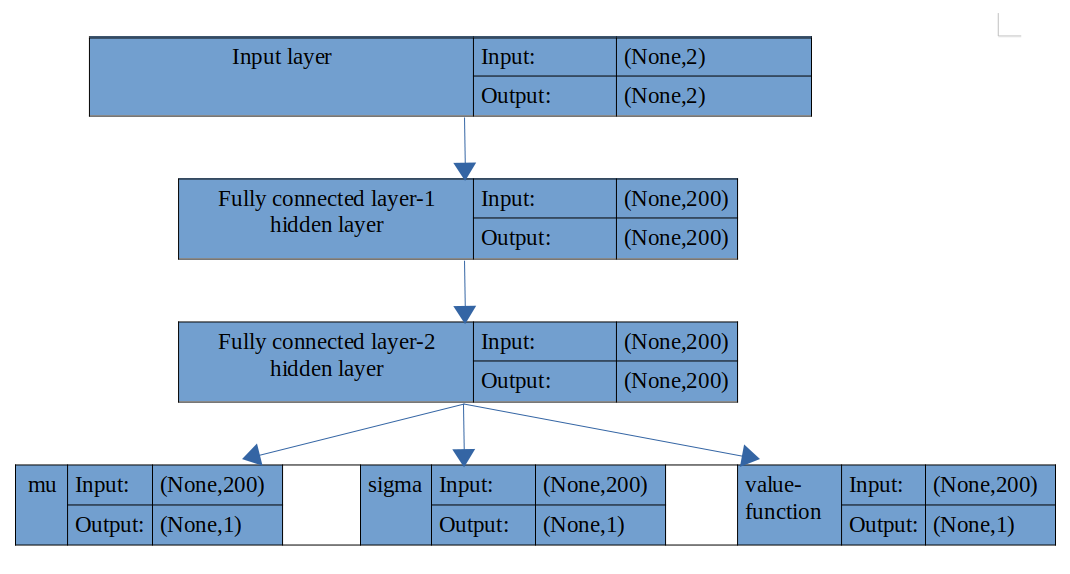
<caption><center> <u> <font color='purple'> Figure 2 </u><font color='purple'>  : Model-Architecture  </center></caption>

    
below I have defined ActorCriticModel Class which follows the above neural-network architecture

In [2]:
class ActorCriticModel(nn.Module):
    def __init__(self, n_input, n_output, n_hidden1,n_hidden2):
        super(ActorCriticModel, self).__init__()
        self.fc1 = nn.Linear(n_input, n_hidden1)
        self.fc2 = nn.Linear(n_hidden1,n_hidden2)
        self.mu = nn.Linear(n_hidden2, n_output)
        self.sigma = nn.Linear(n_hidden2, n_output)
        self.value = nn.Linear(n_hidden2, 1)
        self.distribution = torch.distributions.Normal# using normal distribution first
        
    def forward(self, x): 
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        mu = 2 * torch.tanh(self.mu(x))
        sigma = F.softplus(self.sigma(x)) + 1e-5
        dist = self.distribution(mu.view(1, ).data, sigma.view(1, ).data)
        value = self.value(x)
        return dist, value

In [3]:
class PolicyNetwork():
    def __init__(self, n_state, n_action,n_hidden1=200,n_hidden2=200, lr=0.001):
        self.model = ActorCriticModel(n_state, n_action, n_hidden1,n_hidden2)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)
    def predict(self, s):
        """ Compute the output using the continuous Actor Critic model
        @param s: input state
        @return: Gaussian distribution, state_value """
        self.model.training = True
        return self.model(torch.Tensor(s))
    
    def update(self, returns, log_probs, state_values):
        """Update the weights of the Actor Critic network given the training samples
        @param returns: return (cumulative rewards) for each step in an episode
        @param log_probs: log probability for each step
        @param state_values: state-value for each step"""
        loss = 0
        for log_prob, value, Gt in zip(log_probs, state_values, returns):
            advantage = Gt - value.item()
            policy_loss = -log_prob * advantage
            value_loss = F.smooth_l1_loss(value, Gt)
            loss += policy_loss + value_loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def get_action(self, s):
        """Estimate the policy and sample an action,compute its log probability
        @param s: input state
        @return: the selected action, log probability,predicted state-value """
        dist, state_value = self.predict(s)
        action = dist.sample().numpy()
        log_prob = dist.log_prob(action[0])
        return action, log_prob,state_value

In below cell I have used sklearn libray to preprocess the state of env.

I have taken 10,000 random sample from env. obervation space and fitted with sklearn.preprocessing.StandardScaler() function to normalize the env state so mean is zero and std is 1 =>make computation easier

so in training loop I will call scale_state function which will normalize the state of env.

In [4]:
import sklearn.preprocessing
import numpy as np
state_space_samples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(state_space_samples)

def scale_state(state):
    scaled = scaler.transform([state])
    return scaled[0]

## Simulation Model Class

To get simulation model of the mountain car environment, I have used 
- Gaussian process regression (non-parametric regression)  (Gaussian_Process_Regression in simulation model class)
and some of the knowledge I learned from  https://juanitorduz.github.io/gaussian_process_reg/

$\textbf{Functions}$--
$\textbf{Gaussian_Process_Regression}$  
 
    inputs-
    @ x_train,y_train,x_test
    @ training -- takes boolean value  True -for training the model and false- to get predicted mean and variance at test point
    
    return--
    if training is false 
    @ mu -expected mean value at test points
    @ var - variance at test points
$\textbf{kernel}$
    
    GP squared exponential kernel
    
    input arguments-
    
    @ a, b vector or matrix like
    
$$ k_{ij}=exp(-\frac{(a_i-b_j)^2}{2.l^2})$$

    return-
    
    @ K -covariance matrix

$\textbf{Gaussian_Process_Regression}$  
 
    inputs-
    @ x_train,y_train,x_test
    @ training -- takes boolean value  True -for training the model and false- to get predicted mean and variance at test point
    
    return--
    if training is false 
    @ mu -expected mean value at test points
    @ var - variance at test points

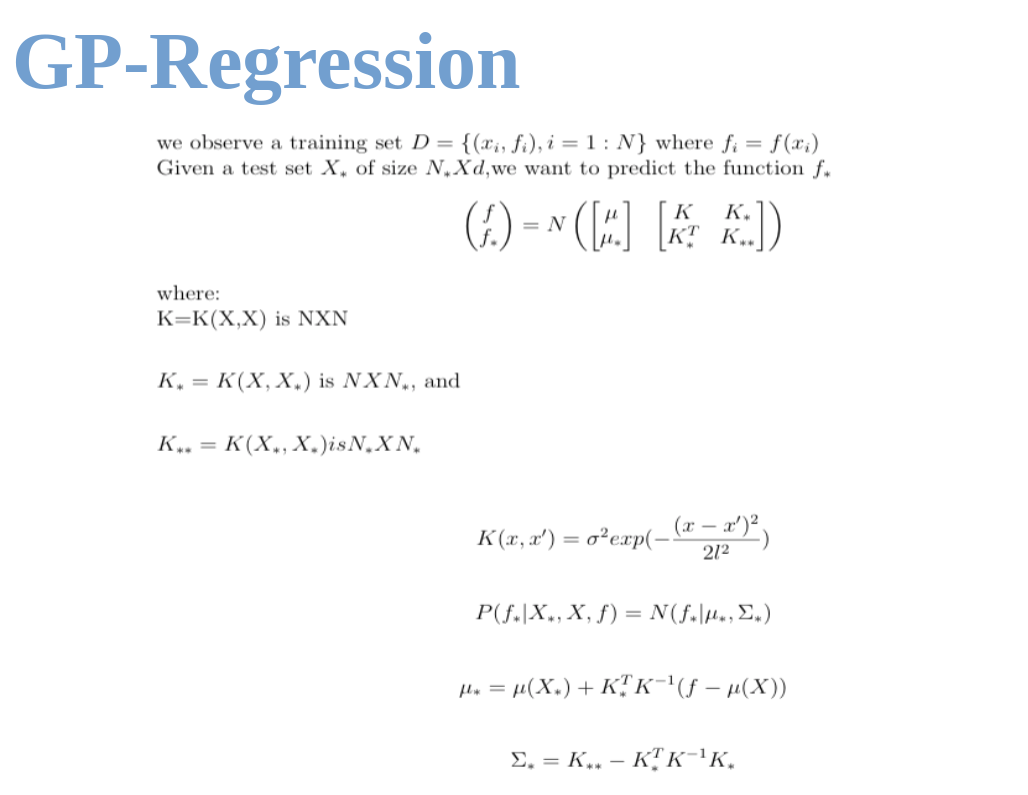
<caption><center> <u> <font color='purple'> Figure 3 </u><font color='purple'>  : GP-Regression  </center></caption>


$\textbf{run_simulation}$
    
    simulation model to train the policy network (optimize the policy)
    
    inputs--
    
    @ mode- if mode='GP' then it simulate GP regression model 
    
    @ estimator- Policy_network class object
    
    @ x_train,y_train
    
    return--
    
    @ reward_sequence,log_probs,state_values

In [5]:
class Simulation_Model:
    
    def __init__(self,w,K,L,s):
        self.w=w
        self.K=K      # covariance matrix
        self.L=L      # cholesky decomposition of K=LL^T
        self.s=s      # error variance for regularization
        
    def get_weight(self):
        return self.w
    
    def set_weight(self,weight):
        self.w=weight
    
    def kernel(self,a, b):
        """ GP squared exponential kernel """
        kernelParameter = 0.1
        sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
        return np.exp(-.5 * (1/kernelParameter) * sqdist)
    
    def Gaussian_Process_Regression(self,x_train,y_train,x_test,training=None):
        ''' fitting both position and velocity using GP-regression'''
        if training:
            self.K=self.kernel(x_train,x_train)
            self.L=np.linalg.cholesky(self.K + self.s*np.eye(x_train.shape[0]))
        else:
            # compute the mean at test points.
            Lk = np.linalg.solve(self.L, self.kernel(x_train, x_test))
            mu = np.dot(Lk.T, np.linalg.solve(self.L, y_train))

            # compute the variance at test points.
            K_ = self.kernel(x_test, x_test)
            s2 = np.diag(K_) - np.sum(Lk**2, axis=0)
            var = np.sqrt(s2)
            return mu,var
    
    def run_simulation(self,x_train,y_train,estimator,mode):
        #print('run simulation')
        reward_sequence=[]
        action_sequence=[]
        state_sequence=[]
        state_values=[]
        log_probs=[]
        
        if mode=='GP':
            #print('i was here')
            for i in range(1000):
                if i==0:
                    # initial state x=[-0.6,-0.4] and v=0
                    x_t=(-0.4+0.6)*np.random.random_sample()-0.6
                    v_t=0.0
                state_sequence.append([x_t,v_t])
                s_t=scale_state([x_t,v_t])
                a_t, log_prob, state_value = estimator.get_action(s_t)
                a_t=action.clip(env.action_space.low[0],env.action_space.high[0])
                if x_t<0.5:
                    reward=-a_t**2
                else:
                    reward=100-a_t**2
                reward_sequence.append(reward)
                #print(f'{i}: a_t:{a_t} log_prob:{log_prob} V:{state_value} R:{reward}')
                action_sequence.append(a_t)
                x_test=np.array([[x_t,v_t,a_t[0]]])
                #print(f'x_test:{x_test}')
                mu,var=self.Gaussian_Process_Regression(x_train,y_train,x_test,False)
                x_t,v_t=mu[0,0],mu[0,1]
                #print(x_t,v_t)
                log_probs.append(log_prob)
                state_values.append(state_value)
                if x_t>=0.5:
                    break
            return reward_sequence,log_probs,state_values

In [6]:
w_initial=np.zeros((10,2))
np.random.seed(42)
mountain_car=Simulation_Model(w_initial,None,None,1e-4)

In [7]:
n_state = env.observation_space.shape[0]
n_action = 1
n_hidden1 = 200
n_hidden2=200
lr = 0.0003
policy_net = PolicyNetwork(n_state, n_action, n_hidden1,n_hidden2, lr)

##### In the below cell I have loaded trained parameters of the model so we don't have to train model every time.

In [11]:
policy_net.model.load_state_dict(torch.load('policy_model_parameter'))

<All keys matched successfully>

### for model learning collecting data points

episode=1

horizon=1000

action are randomly taken

to train the simulated model of the system, I have used only 1 episode because in this system within a episode by choosing random action we can explore most of the system states.

In [ ]:
for i_episode in range(1):
    observation = env.reset()
    action_sequence,state_sequence=[],[observation]
    for t in range(1000):
        env.render()
        action = env.action_space.sample()
        action_sequence.append(action)
        observation, reward, done, info = env.step(action)
        state_sequence.append(observation)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
env.close()

Episode finished after 999 timesteps


##### coverting data into in array form

In [ ]:
previous_state=np.array(state_sequence[0:-1])
sucessor_state=np.array(state_sequence[1:])
action_sequence=np.array(action_sequence)
print(previous_state.shape,sucessor_state.shape,action_sequence.shape)

X=np.hstack((previous_state,action_sequence))
y=sucessor_state
print(X.shape,y.shape)
print('\n \n ')
print('X:')
print(X[0:5])
print('\n \n ')
print('y:')
print(y[0:5])

(999, 2) (999, 2) (999, 1)
(999, 3) (999, 2)

 
 
X:
[[-0.42535058  0.         -0.20847303]
 [-0.42638953 -0.00103895 -0.15474942]
 [-0.42837938 -0.00198985  0.55287111]
 [-0.4302444  -0.00186502  0.69936097]
 [-0.43175142 -0.00150702  0.87920189]]

 
 
y:
[[-0.42638953 -0.00103895]
 [-0.42837938 -0.00198985]
 [-0.4302444  -0.00186502]
 [-0.43175142 -0.00150702]
 [-0.4326198  -0.00086839]]


# learning GP regression model

splitted dataset into training and testing data

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.6,random_state=42)
x_train.shape,x_test.shape

mountain_car.Gaussian_Process_Regression(x_train,None,None,True)
mu,var=mountain_car.Gaussian_Process_Regression(x_train,y_train,x_test,False)
error=y_test-mu
error_pos=(error[:,[0]].T).dot(error[:,[0]])/error.shape[0]
error_vel=(error[:,[1]].T).dot(error[:,[1]])/error.shape[0]

print(f"final position MSE error:{error_pos}")
print(f"final position MSE error:{error_vel}")

final position MSE error:[[1.19301722e-05]]
final position MSE error:[[5.39717139e-08]]


<IPython.core.display.Javascript object>


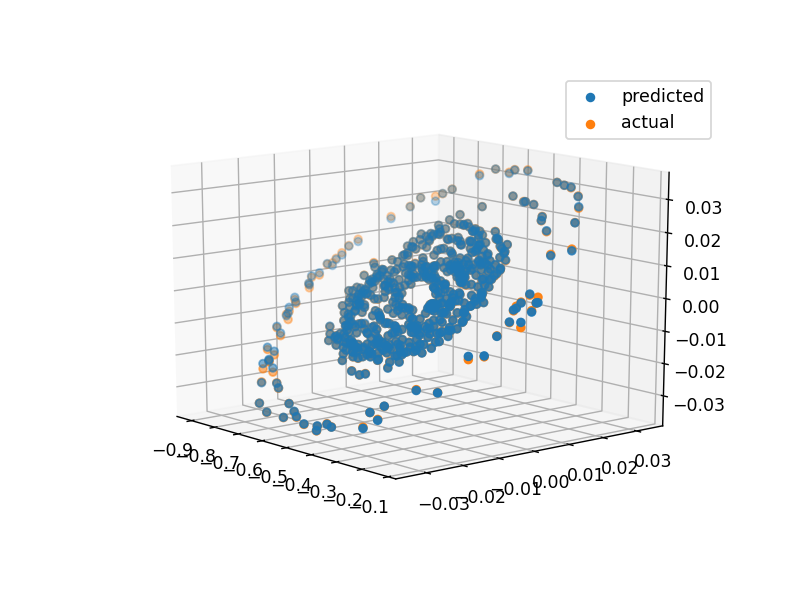

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook
fig=plt.figure()
ax=fig.add_subplot(111,projection='3d')
ax.scatter(x_test[:,0],x_test[:,1],mu[:,1],label='predicted')
ax.scatter(x_test[:,0],x_test[:,1],y_test[:,1],label='actual')
plt.legend()
plt.show()

# Training the policy network from GP-simulation model


I have already loaded trained parameters in the model so no need to run below cell.

In [ ]:
# for episode in range(n_episode):
#     rewards,log_probs,state_values=mountain_car.run_simulation(x_train,y_train,estimator=policy_net,mode='GP')
#     returns = []
#     Gt = 0
#     pw = 0
#     for reward in rewards[::-1]:
#         Gt += gamma ** pw * reward
#         pw += 1
#         returns.append(Gt)
#     returns = returns[::-1]
#     returns = torch.tensor(returns)
#     returns = (returns - returns.mean()) / (returns.std() + 1e-9)
#     policy_net.update(returns, log_probs, state_values)
#     print(f'episode:{episode}')

In [ ]:
gamma=0.99
n_episode = 20

# Now applying the optimized policy on the environment

In [ ]:
n_episode=20
total_reward_episode=[0]*n_episode
for episode in range(n_episode):
    state = env.reset()
    count=0
    while True:
        count+=1
        #print(count)
        env.render()
        state = scale_state(state)
        action, log_prob, state_value = policy_net.get_action(state)
        action = action.clip(env.action_space.low[0],env.action_space.high[0])
        next_state, reward, is_done, _ = env.step(action)
        total_reward_episode[episode] += reward
        if is_done:
            print(f'episode:{episode} no. of steps:{count} total_reward:{total_reward_episode[episode]}')
            break
        state=next_state

episode:0 no. of steps:450 total_reward:82.64970054431885
episode:1 no. of steps:644 total_reward:76.95082346556279
episode:2 no. of steps:465 total_reward:81.8763185356372
episode:3 no. of steps:558 total_reward:78.31845189494832
episode:4 no. of steps:382 total_reward:84.85109157632952
episode:5 no. of steps:441 total_reward:83.79773338978835
episode:6 no. of steps:458 total_reward:81.15541401395966
episode:7 no. of steps:440 total_reward:82.58436741701124
episode:8 no. of steps:632 total_reward:76.19145348504483
episode:9 no. of steps:420 total_reward:84.63487952183114
episode:10 no. of steps:727 total_reward:72.35290471261479
episode:11 no. of steps:802 total_reward:70.9353718820916
episode:12 no. of steps:501 total_reward:79.82817680731779
episode:13 no. of steps:395 total_reward:84.60360546811216
episode:14 no. of steps:380 total_reward:86.09554181609226
episode:15 no. of steps:429 total_reward:83.94839009969758
episode:16 no. of steps:654 total_reward:74.33744381211282
episode:1

In [ ]:
# torch.save(policy_net.model.state_dict(),'policy_model_parameter')

<IPython.core.display.Javascript object>


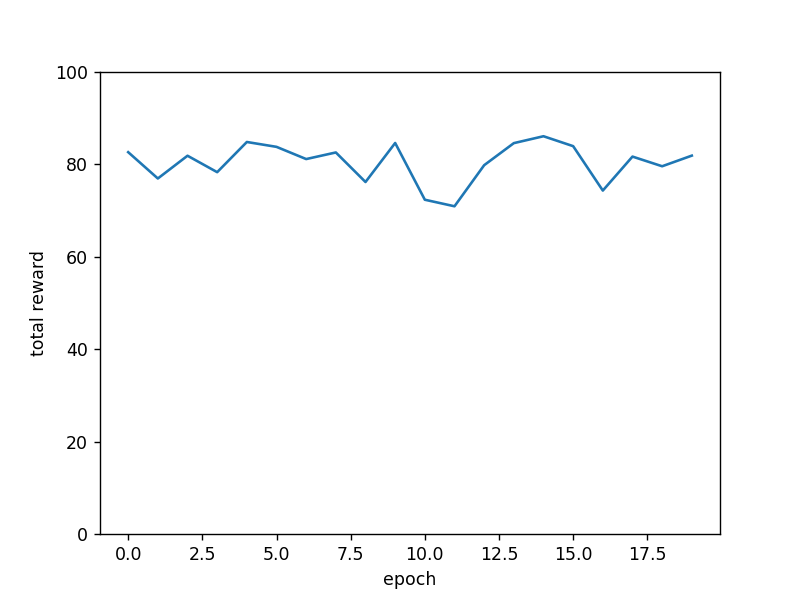

In [ ]:
plt.plot(total_reward_episode)
plt.ylabel('total reward')
plt.xlabel('epoch')
plt.ylim(0,100)
plt.show()

References:
1. http://rail.eecs.berkeley.edu/deeprlcourse-fa17/f17docs/lecture_5_actor_critic_pdf
2. https://medium.com/@asteinbach/actor-critic-using-deep-rl-continuous-mountain-car-in-tensorflow-4c1fb2110f7c
3. https://juanitorduz.github.io/gaussian_process_reg/

#*License*

Copyright <2020> Qiang Ma<COPYRIGHT QIANG MA>

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.